Train samples: 23017
Validation samples: 2877
Test samples: 2878
Example record:
{'instruction': 'extract aspect term-opinion term pairs from the sentence', 'input': "Heck , I like all Mac computers , but they 're all WAY too pricey for the kind of economy the U.S. is going through .", 'output': 'there are no aspect term-opinion term pairs in the sentence.', 'text': "extract aspect term-opinion term pairs from the sentence <NAME> , I like all <NAME> computers , but they 're all WAY too pricey for the kind of economy the U.S. is going through .", 'label': 1, 'input_ids': [0, 16435, 15664, 6659, 1385, 12, 1517, 31210, 1385, 15029, 31, 5, 3645, 28696, 48307, 15698, 2156, 38, 101, 70, 28696, 48307, 15698, 7796, 2156, 53, 51, 128, 241, 70, 26727, 350, 26428, 13, 5, 761, 9, 866, 5, 121, 4, 104, 4, 16, 164, 149, 479, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

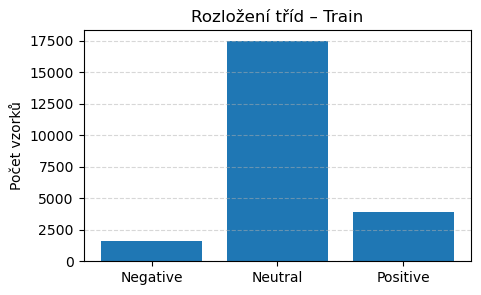


📊 Validation - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2180 (75.77%)
  Positive:   491 (17.07%)


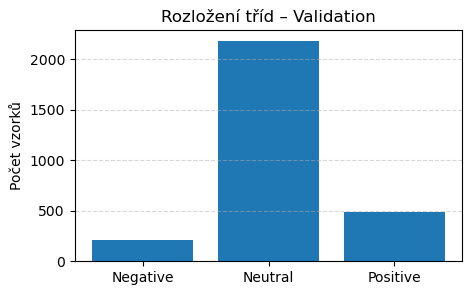


📊 Test - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2181 (75.78%)
  Positive:   491 (17.06%)


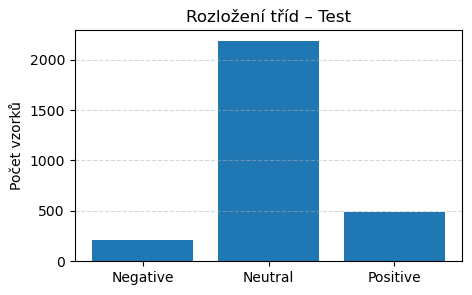


📊 Počet vzorků v třídách: Counter({1: 17443, 2: 3927, 0: 1647})

⚖️ Vypočítané váhy tříd:
  Negative: 4.6584
  Neutral : 0.4399
  Positive: 1.9537


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1313/227063552.py:201: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Step,Training Loss
100,0.857100
200,0.668300
300,0.529400
400,0.515400
500,0.442200
600,0.448600
700,0.436200
800,0.436100
900,0.424300
1000,0.419900



📊 Výsledky na testovacích datech:
eval_loss   : 0.4481
eval_accuracy: 0.9243
eval_precision: 0.9282
eval_recall : 0.9243
eval_f1     : 0.9257
eval_runtime: 5.2610
eval_samples_per_second: 547.0470
eval_steps_per_second: 34.2140
epoch       : 3.0000


In [10]:
from datasets import load_dataset
import re
from transformers import RobertaTokenizer

import pandas as pd
import matplotlib.pyplot as plt

# === 1. Načtení datasetu ===
ds = load_dataset("yuncongli/chat-sentiment-analysis", split="train")

# === 2. Funkce pro maskování citlivých údajů ===
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    # jednoduchá heuristika pro jména (velké písmeno uprostřed věty)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# === 3. Funkce pro extrakci sentimentu ===
def extract_sentiment(output_text: str):
    """
    0 -> Negative
    1 -> Neutral
    2 -> Positive
    """
    if not isinstance(output_text, str):
        return 1  # default neutral

    output_text = output_text.lower()
    has_pos = "positive" in output_text
    has_neg = "negative" in output_text

    if has_pos and not has_neg:
        return 2  # Positive
    elif has_neg and not has_pos:
        return 0  # Negative
    else:
        return 1  # Neutral (nebo mix)

# === 4. Transformace dat ===
def transform(example):
    text = ((example.get("instruction") or "") + " " + (example.get("input") or "")).strip()
    text = mask_sensitive(text)
    label = extract_sentiment(example.get("output", ""))
    return {"text": text, "label": label}

clean_ds = ds.map(transform)

# === 5. Odstranění prázdných nebo krátkých textů ===
clean_ds = clean_ds.filter(lambda x: len(x["text"]) > 5)

# === 6. Tokenizace pro RoBERTa ===
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# === 6.1 Převod labelu na ClassLabel ===
from datasets import ClassLabel
new_features = clean_ds.features.copy()
new_features["label"] = ClassLabel(names=["Negative", "Neutral", "Positive"])
clean_ds = clean_ds.cast(new_features)

# === 6.2 Tokenizace ===
tokenized_ds = clean_ds.map(tokenize, batched=True)

# === 7. Rozdělení dat (stratifikovaně) ===
split_ds = tokenized_ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds = split_ds["train"]
testval = split_ds["test"].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds = testval["train"]
test_ds = testval["test"]

# === 8. Shrnutí ===
print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(valid_ds)}")
print(f"Test samples: {len(test_ds)}")
print("Example record:")
print(train_ds[0])



# === 8. Statistika tříd ===
def show_label_stats(dataset, name="Dataset"):
    # převedeme 'Column' objekt na běžný seznam
    labels = list(dataset["label"])
    df = pd.DataFrame({"label": labels})

    counts = df["label"].value_counts().sort_index()
    total = counts.sum()

    label_names = ["Negative", "Neutral", "Positive"]
    print(f"\n{name} - Statistika tříd:")
    for i, count in counts.items():
        perc = (count / total) * 100
        print(f"  {label_names[i]:<8}: {count:5d} ({perc:5.2f}%)")

    # volitelný graf
    plt.figure(figsize=(5,3))
    plt.bar(label_names, counts)
    plt.title(f"Rozložení tříd – {name}")
    plt.ylabel("Počet vzorků")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

# Zavolej pro všechny datasety
show_label_stats(train_ds, "Train")
show_label_stats(valid_ds, "Validation")
show_label_stats(test_ds, "Test")

# === 9. Výpočet vah tříd pro trénování ===
import torch
from collections import Counter

def compute_class_weights(dataset):
    labels = list(dataset["label"])
    counter = Counter(labels)
    print("Počet vzorků v třídách:", counter)
    
    total = sum(counter.values())
    num_classes = len(counter)
    weights = [total / (num_classes * counter[i]) for i in range(num_classes)]
    
    class_weights = torch.tensor(weights, dtype=torch.float)
    print("Vypočítané váhy tříd:")
    for i, w in enumerate(weights):
        label_name = ["Negative", "Neutral", "Positive"][i]
        print(f"  {label_name:<8}: {w:.4f}")
    
    return class_weights

# --- zavolej na trénovacím datasetu ---
class_weights = compute_class_weights(train_ds)


# === 10. Trénování modelu s váhami tříd ===
from transformers import (
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import torch
import torch.nn as nn

# Načti model (3 výstupní třídy)
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

# Přesun na GPU pokud je k dispozici
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === Custom loss funkce s aplikovanými vahami ===
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


# === Data collator (správné paddingy) ===
data_collator = DataCollatorWithPadding(tokenizer)

# === Training arguments ===
training_args = TrainingArguments(
    output_dir="./roberta-sentiment",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
)


# === Metoda pro vyhodnocení ===
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }

# === Inicializace Traineru ===
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# === Spuštění trénování ===
trainer.train()

# === Vyhodnocení na testovacích datech ===
metrics = trainer.evaluate(test_ds)
print("Výsledky na testovacích datech:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")


In [4]:
!pip install --upgrade transformers datasets


In [7]:
import transformers
print(transformers.__version__)


4.57.0


In [8]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)


transformers.training_args


Train samples: 23017
Validation samples: 2877
Test samples: 2878
Example record:
{'instruction': 'extract aspect term-opinion term pairs from the sentence', 'input': "Heck , I like all Mac computers , but they 're all WAY too pricey for the kind of economy the U.S. is going through .", 'output': 'there are no aspect term-opinion term pairs in the sentence.', 'text': "extract aspect term-opinion term pairs from the sentence <NAME> , I like all <NAME> computers , but they 're all WAY too pricey for the kind of economy the U.S. is going through .", 'label': 1, 'input_ids': [0, 16435, 15664, 6659, 1385, 12, 1517, 31210, 1385, 15029, 31, 5, 3645, 28696, 48307, 15698, 2156, 38, 101, 70, 28696, 48307, 15698, 7796, 2156, 53, 51, 128, 241, 70, 26727, 350, 26428, 13, 5, 761, 9, 866, 5, 121, 4, 104, 4, 16, 164, 149, 479, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

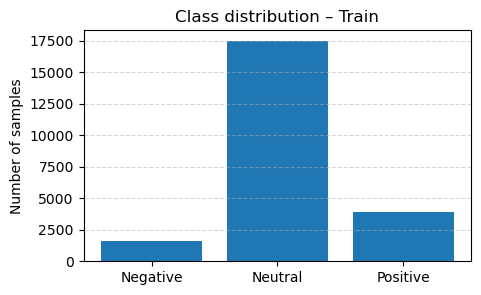


Validation - Class distribution:
  Negative:   206 ( 7.16%)
  Neutral :  2180 (75.77%)
  Positive:   491 (17.07%)


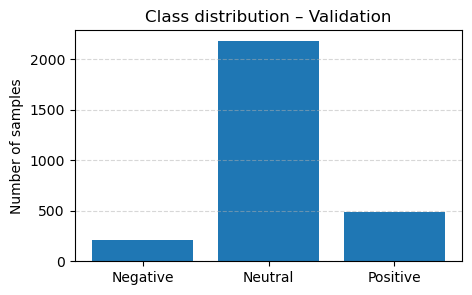


Test - Class distribution:
  Negative:   206 ( 7.16%)
  Neutral :  2181 (75.78%)
  Positive:   491 (17.06%)


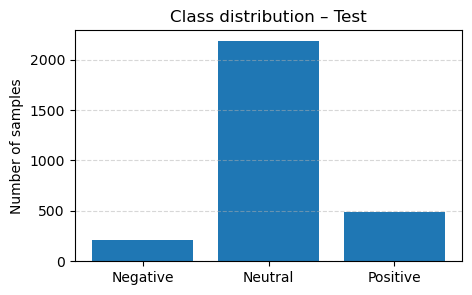

In [12]:
from datasets import load_dataset
import re
from transformers import RobertaTokenizer

import pandas as pd
import matplotlib.pyplot as plt

# === 1. Load dataset ===
ds = load_dataset("yuncongli/chat-sentiment-analysis", split="train")

# === 2. Function to mask sensitive information ===
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    # simple heuristic for names (capital letter in middle of sentence)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# === 3. Function to extract sentiment ===
def extract_sentiment(output_text: str):
    """
    0 -> Negative
    1 -> Neutral
    2 -> Positive
    """
    if not isinstance(output_text, str):
        return 1  # default neutral

    output_text = output_text.lower()
    has_pos = "positive" in output_text
    has_neg = "negative" in output_text

    if has_pos and not has_neg:
        return 2  # Positive
    elif has_neg and not has_pos:
        return 0  # Negative
    else:
        return 1  # Neutral (or mixed)

# === 4. Transform the dataset ===
def transform(example):
    text = ((example.get("instruction") or "") + " " + (example.get("input") or "")).strip()
    text = mask_sensitive(text)
    label = extract_sentiment(example.get("output", ""))
    return {"text": text, "label": label}

clean_ds = ds.map(transform)

# === 5. Remove empty or very short texts ===
clean_ds = clean_ds.filter(lambda x: len(x["text"]) > 5)

# === 6. Tokenization for RoBERTa ===
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# === 6.1 Convert label to ClassLabel ===
from datasets import ClassLabel
new_features = clean_ds.features.copy()
new_features["label"] = ClassLabel(names=["Negative", "Neutral", "Positive"])
clean_ds = clean_ds.cast(new_features)

# === 6.2 Tokenization ===
tokenized_ds = clean_ds.map(tokenize, batched=True)

# === 7. Split dataset (stratified) ===
split_ds = tokenized_ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds = split_ds["train"]
testval = split_ds["test"].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds = testval["train"]
test_ds = testval["test"]

# === 8. Summary ===
print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(valid_ds)}")
print(f"Test samples: {len(test_ds)}")
print("Example record:")
print(train_ds[0])

# === 9. Class distribution for train, validation, and test sets ===
def show_label_stats(dataset, name="Dataset"):
    # convert 'Column' object to a regular list
    labels = list(dataset["label"])
    df = pd.DataFrame({"label": labels})

    counts = df["label"].value_counts().sort_index()
    total = counts.sum()

    label_names = ["Negative", "Neutral", "Positive"]
    print(f"\n{name} - Class distribution:")
    for i, count in counts.items():
        perc = (count / total) * 100
        print(f"  {label_names[i]:<8}: {count:5d} ({perc:5.2f}%)")

    # optional plot
    plt.figure(figsize=(5,3))
    plt.bar(label_names, counts)
    plt.title(f"Class distribution – {name}")
    plt.ylabel("Number of samples")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

# Show class distribution for all splits
show_label_stats(train_ds, "Train")
show_label_stats(valid_ds, "Validation")
show_label_stats(test_ds, "Test")



DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 28772
    })
})
Unikátní sentimenty po extrakci: ['negative' 'positive' 'neutral']
sentiment
positive    1066
negative     566
neutral       78
Name: count, dtype: int64


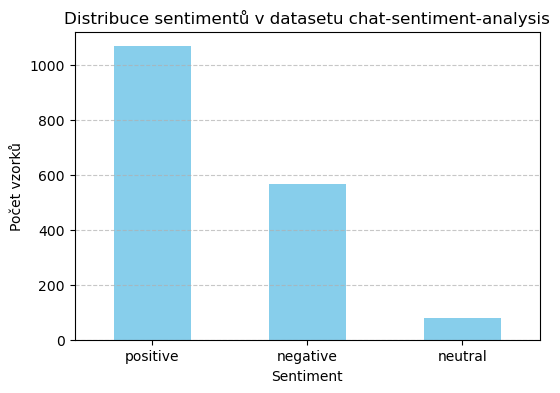

In [14]:
from datasets import load_dataset 

# Načtení datasetu z Hugging Face
dataset = load_dataset("yuncongli/chat-sentiment-analysis")

# Zobrazení dostupných splitů
print(dataset)

import pandas as pd
import matplotlib.pyplot as plt

# Funkce pro extrakci sentimentu
def extract_sentiment(output_str):
    if not output_str:
        return None
    try:
        parts = output_str.split(',')
        if len(parts) >= 3:
            sentiment = parts[2].strip()
            sentiment = sentiment.replace(")", "").replace("'", "").replace("]", "").replace("[", "")
            sentiment = sentiment.lower()
            # Jen validní hodnoty
            if sentiment in ["positive", "negative", "neutral"]:
                return sentiment
    except:
        return None
    return None

# Načtení datasetu
df = dataset["train"].to_pandas()

# Extrakce sentimentu
df["sentiment"] = df["output"].apply(extract_sentiment)

# Odstranit None
df_clean = df.dropna(subset=["sentiment"])

# Zkontrolovat unikátní sentimenty
print("Unikátní sentimenty po extrakci:", df_clean["sentiment"].unique())

# Distribuce
sentiment_counts = df_clean["sentiment"].value_counts()
print(sentiment_counts)

# Vykreslení grafu
plt.figure(figsize=(6,4))
sentiment_counts.plot(kind="bar", color="skyblue")
plt.title("Distribuce sentimentů v datasetu chat-sentiment-analysis")
plt.xlabel("Sentiment")
plt.ylabel("Počet vzorků")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/28772 [00:00<?, ? examples/s]

Map:   0%|          | 0/64636 [00:00<?, ? examples/s]

Filter:   0%|          | 0/93408 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/28772 [00:00<?, ? examples/s]

Map:   0%|          | 0/28772 [00:00<?, ? examples/s]

Train samples: 23017
Validation samples: 2877
Test samples: 2878

📊 Train - Statistika tříd:
  Negative:  1647 ( 7.16%)
  Neutral : 17443 (75.78%)
  Positive:  3927 (17.06%)


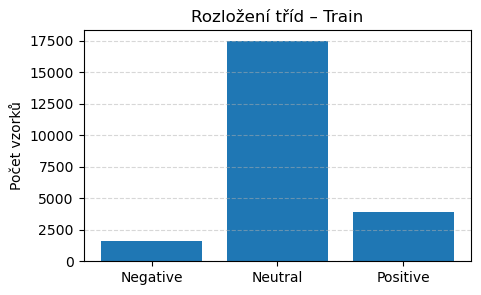


📊 Validation - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2180 (75.77%)
  Positive:   491 (17.07%)


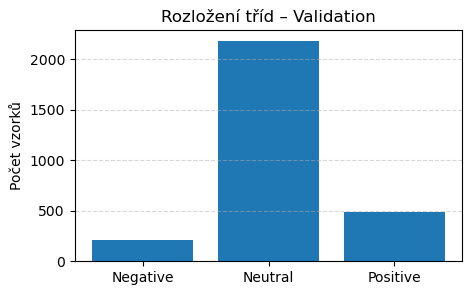


📊 Test - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2181 (75.78%)
  Positive:   491 (17.06%)


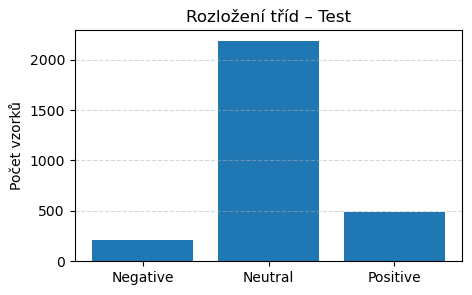

In [17]:
from datasets import load_dataset, concatenate_datasets
import re
from transformers import RobertaTokenizer
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Načtení datasetů ===
ds1 = load_dataset("yuncongli/chat-sentiment-analysis", split="train")
ds2 = load_dataset("csv", data_files="empathetic_dialogues.csv", split="train")



# === 2. Funkce pro maskování citlivých údajů ===
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# === 3. Funkce pro extrakci sentimentu z původního datasetu ===
def extract_sentiment(output_text: str):
    if not isinstance(output_text, str):
        return 1
    output_text = output_text.lower()
    has_pos = "positive" in output_text
    has_neg = "negative" in output_text
    if has_pos and not has_neg:
        return 2
    elif has_neg and not has_pos:
        return 0
    else:
        return 1

# === 4. Normalizace datasetů do stejného formátu ===
def transform_chat_sentiment(example):
    text = ((example.get("instruction") or "") + " " + (example.get("input") or "")).strip()
    text = mask_sensitive(text)
    label = extract_sentiment(example.get("output", ""))
    return {"text": text, "label": label}

def transform_empathetic(example):
    # dataset empathetic_dialogues má jiné sloupce (např. "utterance" nebo "context")
    text = (example.get("utterance") or example.get("context") or "").strip()
    text = mask_sensitive(text)
    # sentiment v tomto datasetu není – můžeš ho vytvořit pomocí jednoduché heuristiky
    # nebo později použít jen pro pre-trénink
    return {"text": text, "label": 1}  # neutrální jako placeholder

clean_ds1 = ds1.map(transform_chat_sentiment)
clean_ds2 = ds2.map(transform_empathetic)

# === 5. Spojení datasetů ===
combined_ds = concatenate_datasets([clean_ds1, clean_ds2])

# === 6. Filtrace krátkých textů ===
combined_ds = combined_ds.filter(lambda x: len(x["text"]) > 5)

# === 7. Tokenizace ===
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

from datasets import ClassLabel
new_features = combined_ds.features.copy()
new_features["label"] = ClassLabel(names=["Negative", "Neutral", "Positive"])
combined_ds = combined_ds.cast(new_features)

tokenized_ds = combined_ds.map(tokenize, batched=True)

# === 8. Rozdělení dat ===
split_ds = tokenized_ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds = split_ds["train"]
testval = split_ds["test"].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds = testval["train"]
test_ds = testval["test"]

# === 9. Výpis ===
print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(valid_ds)}")
print(f"Test samples: {len(test_ds)}")

# === 10. Statistika tříd ===
def show_label_stats(dataset, name="Dataset"):
    labels = list(dataset["label"])
    df = pd.DataFrame({"label": labels})
    counts = df["label"].value_counts().sort_index()
    total = counts.sum()
    label_names = ["Negative", "Neutral", "Positive"]
    print(f"\n📊 {name} - Statistika tříd:")
    for i, count in counts.items():
        perc = (count / total) * 100
        print(f"  {label_names[i]:<8}: {count:5d} ({perc:5.2f}%)")
    plt.figure(figsize=(5,3))
    plt.bar(label_names, counts)
    plt.title(f"Rozložení tříd – {name}")
    plt.ylabel("Počet vzorků")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

show_label_stats(train_ds, "Train")
show_label_stats(valid_ds, "Validation")
show_label_stats(test_ds, "Test")
